# Neural Receiver with Support for Variable Modulation and Coding Schemes

This notebook introduces a reconfigurable neural receiver architecture which can adapt to different modulation schemes per user without the need for any re-training.

## Motivation
Neural receivers that combine data-driven channel estimation and MIMO data detection have demonstrated significant performance benefits over classical receivers in [[1, 2]](#references). However, none of the proposed methods has yet been extended to support a variable modulation and coding scheme (MCS). As the channel coding scheme is transparent to the NRX, the research focus lies on supporting variable (QAM) constellations within a shared neural network.

In this notebook we present a novel neural receiver architecture with support for variable MCSs (Var-MCS NRX) that is capable to closely approach the TBLER performance of the single-MCS NRX baselines from [[2]](#references). In addition to the LLR masking scheme from [[3]](#references), we present a novel approach that implements small MCS-specific input and output layers and shares the iterative CGNN layers from [[2]](#references) for all MCSs. In section [System Model and NRX with Variable MCS](#System-Model-and-NRX-with-Variable-MCS) we detail the Var-MCS NRX architecture and how to use the framework for variable- and mixed-MCS simulations and training.

Our Var-MCS NRX is trained with a novel [training scheme](#Training-the-Neural-Receiver-with-Variable-MCS) that implements a random MCS selection for a random number of transmitters, that is also combined with MCS-specific training SNR offsets. 

Furthermore, this notebook demonstrates how to use the system model for variable- and mixed-MCS training and simulation.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [System Model and NRX with Variable MCS](#System-Model-and-NRX-with-Variable-MCS)
* [Training the Neural Receiver with Variable MCS](#Training-the-Neural-Receiver-with-Variable-MCS)
* [Performance Evaluation](#Performance-Evaluation)
* [References](#References)

## GPU Configuration and Imports

Remark: Plotting itself does not need GPU/TensorFlow support.
However, the plotting function initializes the system parameters which would otherwise occupy all available GPUs.

In [1]:
# import relevant packages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tf warnings

gpu_num = 0 # Number of the GPU to be used
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

# Import libraries
import sys
sys.path.append('../') # to import utils
from utils import plot_results, plot_gp

from sionna.utils import sim_ber
from utils.e2e_model import E2E_Model_Mixed_MCS
from utils.parameters import Parameters
from utils.utils import load_weights
import numpy as np
import pickle
import sionna as sn

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

Number of GPUs available : 2
Only GPU number 0 used.


## System Model and NRX with Variable MCS

Compared to single-MCS scenarios considered in other notebooks within this codebase, we enable support for variable MCS by defining multiple entries in the `mcs_index` list in the configuration file. Considering the `nrx_rt_var_mcs.cfg` configuration file, we have extended the Real-Time NRX configuration discussed in the `nrx_architecture.ipynb` notebook to also support QPSK constellations, by supporting MCS index 9 (QPSK) in addition to MCS index 14 (16-QAM). Furthermore, the `nrx_large_var_mcs_64qam_masking.cfg` configuration file supports MCS index 9 (QPSK), 14 (16-QAM) and 19 (64-QAM).

During training and simulation, the UE-to-MCS association can be selected by an MCS mask and by an MCS evaluation index. An MCS mask can be defined as a one-hot mask of shape `[batch_size, num_tx, len(mcs_index)]` which allows to select the MCS of each transmitter in each batch sample. As discussed later in detail, the simulation model can be simplified to only evaluate certain MCS indices by the variable `mcs_arr_eval_idx` which selects the evaluation index (i.e., the position) of the `mcs_index` array (defaults to `0` which selects `mcs_index[0]`).

### Variable MCS System Model

As illustrated in the figure below, the capability to simulate any arbitrary MCS-to-UE selection requires simulating different PUSCH transmitters for all possible MCSs. To avoid time-consuming re-builds of the TensorFlow (XLA) graph, we multiply the PUSCH transmitter outputs from all supported MCS schemes with the MCS mask, i.e., the MCS mask selects the active MCS scheme per user. As a result, the resulting sum of masked transmit signals is composed of constellation symbols with the desired MCSs.

As transport-block (TB) receiver processing and forward error correction decoding is computationally complex, the variable `mcs_arr_eval_idx` selects the MCS for the receiver. While we compute the training loss always for all MCSs, for evaluation we only apply the receiver for one MCS.

In order to evaluate mixed MCS scenarios, we implemented the wrapper class `E2E_Model_Mixed_MCS` which enables selecting only the received signals of a desired UE associated with the MCS index of interest.

*Remark:* as the physical (wireless) channel can only implement one noise variance `no` that is independent of variable MCS transmitters, one needs to be careful when comparing rate-adjusted SNRs (i.e., if the configuration file implements `ebno=True`). Rate-adjusted SNR is always computed for `mcs_index[mcs_arr_eval_idx]` if `mcs_arr_eval_idx` is a scalar, or for `mcs_index[mcs_arr_eval_idx[0]]` if `mcs_arr_eval_idx` is a list.


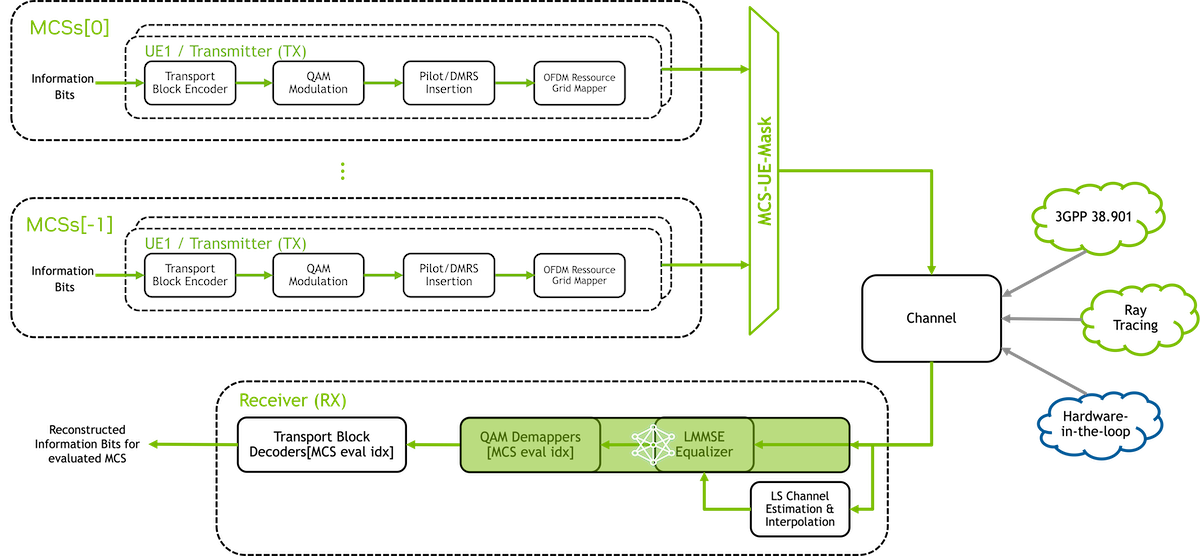

### Variable MCS NRX

Compared to the single-MCS NRX architecture discussed in the [architecture notebook](nrx_architecture.ipynb), we study two approaches to extend the NRX architecture from [[2]](#references) to support variable modulation schemes: (i) *masking* of higher-order LLRs, and (ii) *MCS-specific input and output layers* (abbreviated by Var-IO).

The first approach builds upon an idea mentioned in [[1]](#references),
which was later implemented for a neural demapper in [[3]](#references). Due to the recursive structure
of bit labels from Gray-code-labeled QAM constellations,
where constellation points from higher-order modulations are
recursively derived from lower-order points. The higher-order
bit labels then re-apply the lower-order bit labels, and extended
by the additional higher-order bits. For example, if we compare
16-QAM with QPSK, all 16-QAM constellation points within
a quadrant of the complex plane share the same lower-order
bits as the corresponding QPSK constellation point. Thus, by
masking of unused higher-order LLR outputs, an NRX for the
highest modulation order can be adopted also for detecting
lower-order constellation points. However, this requires additional training considerations as mentioned below and only works for Gray-code labeled QAM constellations.

While our novel training scheme turned out effective to train a Var-MCS-NRX with the masking scheme for Gray-code labeled QAM constellations, we also put forward an alternative method for implementing a more versatile Var-MCS-NRX. By applying modulation-specific `StateInit` and `ReadoutLLRs` layers (denoted as input and output layers, respectively), we give the NRX additional flexibility to fit to varying modulation orders, while sharing the majority of weights (in the `CGNIt` blocks) for all modulation schemes. Modulation-specific input layers are motivated by improving data-aided channel estimation. Modulation-specific output layers are motivated by giving the model the flexibility to learn *matched* demapping, and only need to implement the number of LLR outputs needed for the corresponding modulation order. This *Var-IO scheme* (depicted below) can be also useful with more general, non-Gray-code-labeled constellations, or custom constellations obtained from end-to-end learning [[4]](#references). Note that although MCS-specific IO layers lead to a slightly increased number of weights, the number of active weights (and thus also the inference latency) is the same as for the masking scheme, or the single-MCS NRX baseline.

*Remark:* The MCS-UE-mask must be known to the Var-MCS NRX in the current implementation. As the UEs' MCS schedule is typically known to a 5G NR receiver, we consider this as a valid assumption. However, we leave it for future research to extend the Var-MCS NRX to implicitly infer the MCS-UE-mask from the receive signal.


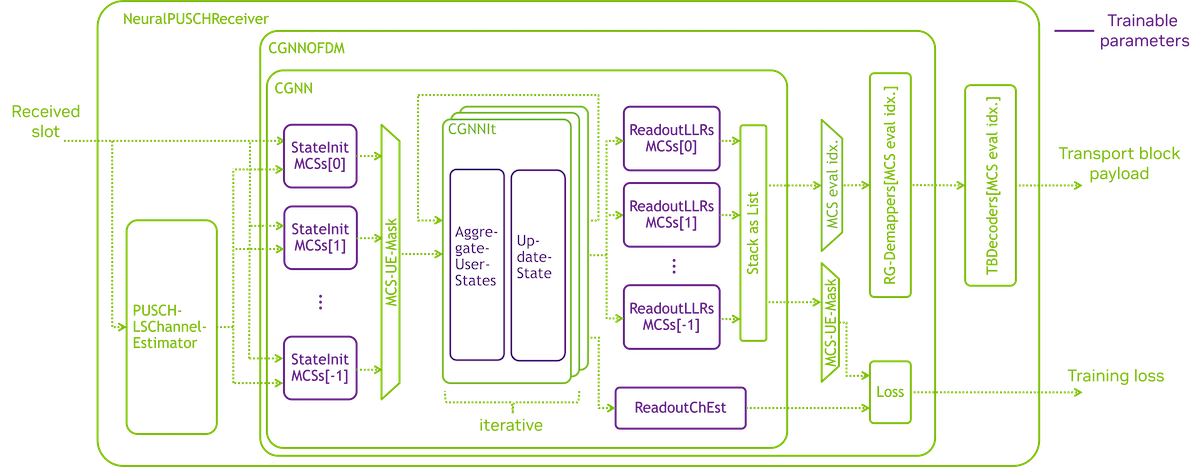

## Training the Neural Receiver with Variable MCS

The Var-MCS NRX can be trained by executing the following code. However, this might take multiple days and we therefore recommend to use the pre-trained weights included in this codebase.

In [ ]:
# As training takes several hours/days, we recommend to run this command in the terminal outside of a jupyter notebook.

# Training the RT NRX architecture with Var-IO layers for QPSK & 16-QAM:
os.system("python ../scripts/train_neural_rx.py -config_name nrx_rt_var_mcs.cfg -gpu 0")

# Training the Large NRX architecture with Masking scheme for QPSK & 16-QAM & 64-QAM:
os.system("python ../scripts/train_neural_rx.py -config_name nrx_large_var_mcs_64qam_masking.cfg -gpu 0")

Compared to training a single-MCS NRX, training the Var-MCS NRX requires a few additional considerations that we will discuss in the following.

### Random MCS-to-UE Mask and Random Number of Active Transmitters

As for training the single-MCS NRX, the number of active transmitters is sampled from a triangular distribution during training. In order to ensure that all MCS-to-UE combinations are represented during the training process and are taken into account for gradient computation, we also randomly sample the MCS-to-UE mask during training.

In the current implementation, the MCS-to-UE association is independent and
identically distributed (iid.) following a uniform distribution. This means that
it is equally likely that a transmitter is assigned with either of the elements
in the `mcs_index` list during training. However, the simulation code also
allows for non-uniform MCS probabilities with the configuration variable
`mcs_training_probs` that defines MCS selection probabilities for each
MCS index (inner list) and for each number of active UEs (outer list).

### Training SNR Range

As discussed before, the rate-adjusted SNR (i.e., Eb/No) is computed for the first MCS index. Therefore, the SNR range specified by `min_training_snr_db` and `max_training_snr_db` is with respect to the first MCS(-evaluation) index (if `ebno=True`).

As the physical channel can only set one common noise variance that is
independent of the MCS of the transmitters, the second MCS (assuming the second
to be larger than the first MCS) will see a rate-adjusted SNR that is
effectively lower than for the first MCS. For our example with MCS index 9 and
14, this corresponds to a shift of approximately 2dB. Due to higher error rates
at lower rate-adjusted SNR, the higher MCS will then result in a higher loss,
which would dominate the batch loss. This can be compensated for by MCS-specific
SNR offsets, described next.

### MCS-specific SNR Offsets

In order to compensate higher loss with higher modulation orders, we introduce SNR offsets (in dB) that are added to the randomly selected SNR values (in dB) during training. In the configuration file, the variable `mcs_training_snr_db_offset` allows defining offsets for all possible numbers of active users. Then, the random number of active users and the random MCS-to-UE selection decides on which offsets are added (in dB) to the SNR realization.

For our example with MCS indices 9 and 14, we observed that the rate adjusted SNR is shifted by approximately 2dB. In addition to that, we observed that it takes approximately 2dB of higher rate adjusted SNR for 16-QAM to match the TBLER of QPSK. This justifies our selection of the SNR offset for one and two UEs, as follows:
- *One active transmitter:* 4dB offset for one active 16-QAM transmitter
- *Two active transmitters:* 2dB offset for one active 16-QAM transmitter (mixed QPSK and 16-QAM batch sample). For two active 16-QAM transmitters, this adds up to an offset of 4dB (all 16-QAM batch sample), which again approximately bridges the gap to QPSK in terms of loss and TBLER.

For MCS index 19 (64-QAM), we empirically observed good performance with an SNR offset of 7dB relative to MCS index 9 (QPSK).

## Performance Evaluation

In the following, we compare the Var-MCS NRX to single-MCS NRX baselines and other classical baselines. We start by comparing the performance in single-MCS scenarios and will also present a performance evaluation in a mixed-MCS scenario.

*Remark:* We focus for our performance evaluations on the small real-time (RT) NRX model for QPSK and 16-QAM in order to restrict the model capacity to avoid implicitly learning multiple single-MCS receivers in one architecture. As detecting 64-QAM constellations is a more difficult detection problem, we study the Var-MCS NRX with support up to 64-QAM with the *Large NRX* architecture.

With the following code, you can evaluate the Var-MCS NRX performance for all possible MCSs (single-MCS scenarios) and for all possible number of UEs.

In [ ]:
os.system("python ../scripts/evaluate.py -config_name nrx_rt_var_mcs.cfg -eval_nrx_only")
os.system("python ../scripts/evaluate.py -config_name nrx_large_var_mcs_64qam_masking.cfg -eval_nrx_only")

### QPSK Performance

The following code executes the benchmark for the QPSK baselines.

In [ ]:
os.system("python ../scripts/evaluate.py -config_name nrx_rt_qpsk.cfg")

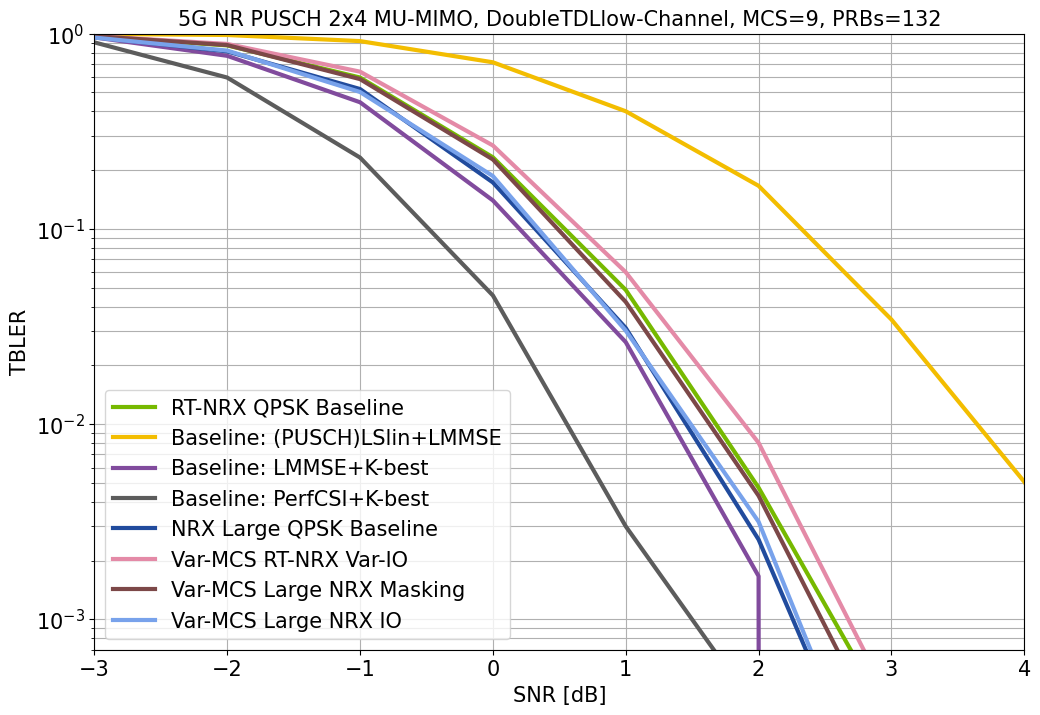

In [2]:
config_name = "nrx_rt_qpsk.cfg"
num_tx_eval = 2 # depends on what has been evaluated in evaluate.py before

# generate a new figure and plot the QPSK baseline results
fig = plot_results(config_name, num_tx_eval=num_tx_eval, xlim=[0,7], ylim=[7e-4,1],
                   labels=["RT-NRX QPSK Baseline", "Baseline: (PUSCH)LSlin+LMMSE","Baseline: LMMSE+K-best", "Baseline: PerfCSI+K-best"])

fig = plot_results(fig=fig, config_name="nrx_large_qpsk.cfg", num_tx_eval=num_tx_eval,
             xlim=[-3,4], ylim=[7e-4,1], color_offset=4, labels=["NRX Large QPSK Baseline"], mcs_arr_eval_idx=0)

# we now add additional results from the Var-MCS NRX in the same figure
fig = plot_results(fig=fig, config_name="nrx_rt_var_mcs.cfg", num_tx_eval=num_tx_eval,
             xlim=[-3,4], ylim=[7e-4,1], color_offset=5, labels=["Var-MCS RT-NRX Var-IO"], mcs_arr_eval_idx=0)

fig = plot_results(fig=fig, config_name="nrx_large_var_mcs_64qam_masking.cfg", num_tx_eval=num_tx_eval,
             xlim=[-3,4], ylim=[7e-4,1], color_offset=6, labels=["Var-MCS Large NRX Masking"], mcs_arr_eval_idx=0, sim_idx=0)

fig = plot_results(fig=fig, config_name="nrx_large_var_mcs.cfg", num_tx_eval=num_tx_eval,
             xlim=[-3,4], ylim=[7e-4,1], color_offset=7, labels=["Var-MCS Large NRX IO"], mcs_arr_eval_idx=0, sim_idx=0);

### 16-QAM Performance
For the 16-QAM baselines, we can reuse the results from the RT-NRX in `nrx_architecture.ipynb`, or resimulate with the following code.

In [ ]:
os.system("python ../scripts/evaluate.py -config_name nrx_rt.cfg")

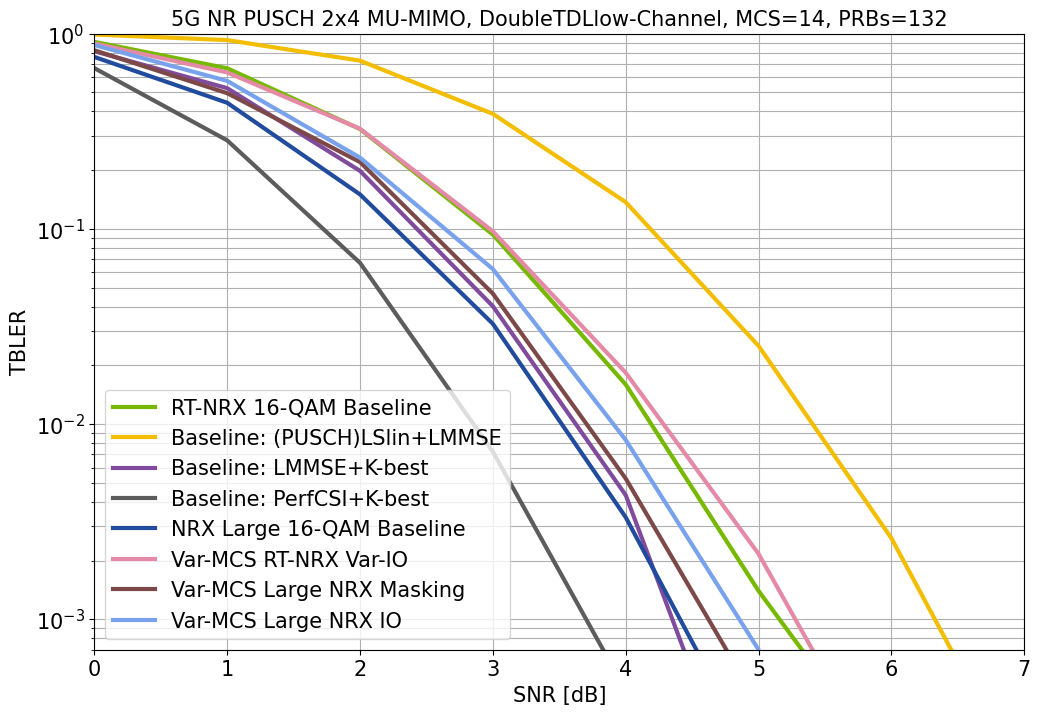

In [3]:
config_name = "nrx_rt.cfg"
num_tx_eval = 2 # depends on what has been evaluated in evaluate.py before

# generate a new figure and plot the 16-QAM baseline results
fig = plot_results(config_name, num_tx_eval=num_tx_eval, xlim=[0,7], ylim=[7e-4,1],
                   labels=["RT-NRX 16-QAM Baseline", "Baseline: (PUSCH)LSlin+LMMSE","Baseline: LMMSE+K-best", "Baseline: PerfCSI+K-best"]);

fig = plot_results(fig=fig, config_name="nrx_large.cfg", num_tx_eval=num_tx_eval,
             xlim=[0,7], ylim=[7e-4,1], color_offset=4, labels=["NRX Large 16-QAM Baseline"], mcs_arr_eval_idx=0)

# we now add additional results from the Var-MCS NRX in the same figure
fig = plot_results(fig=fig, config_name="nrx_rt_var_mcs.cfg", num_tx_eval=num_tx_eval,
             xlim=[0,7], ylim=[7e-4,1], color_offset=5, labels=["Var-MCS RT-NRX Var-IO"], mcs_arr_eval_idx=1)

fig = plot_results(fig=fig, config_name="nrx_large_var_mcs_64qam_masking.cfg", num_tx_eval=num_tx_eval,
             xlim=[0,7], ylim=[7e-4,1], color_offset=6, labels=["Var-MCS Large NRX Masking"], mcs_arr_eval_idx=1, sim_idx=0)

fig = plot_results(fig=fig, config_name="nrx_large_var_mcs.cfg", num_tx_eval=num_tx_eval,
             xlim=[0,7], ylim=[7e-4,1], color_offset=7, labels=["Var-MCS Large NRX IO"], mcs_arr_eval_idx=1, sim_idx=0);

### 64-QAM Performance

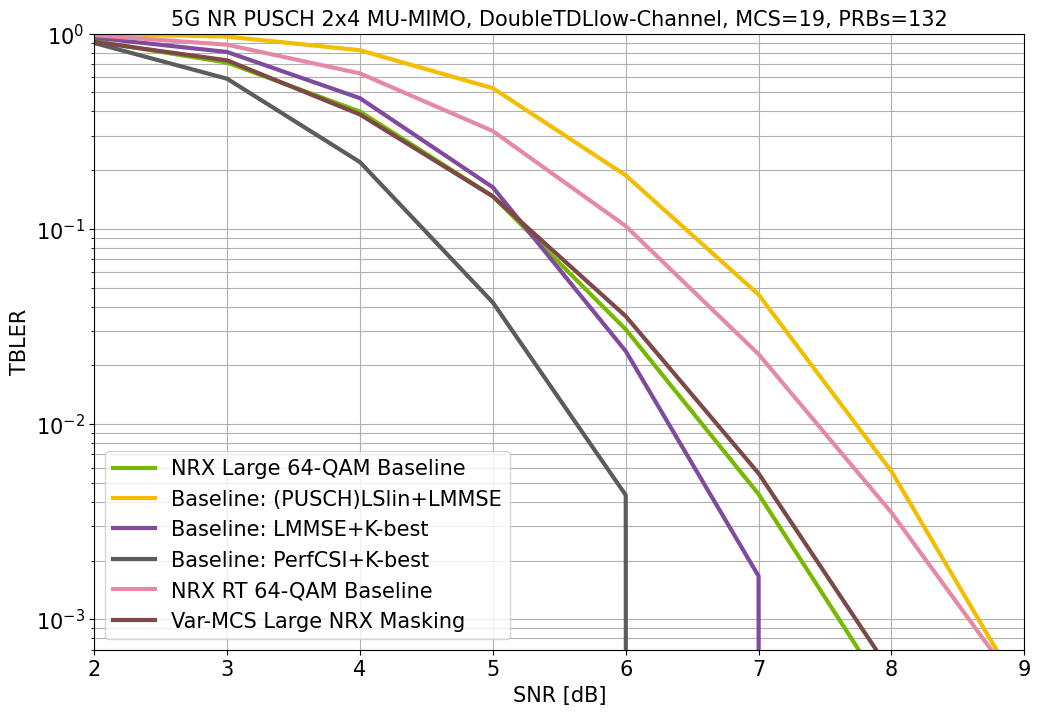

In [4]:
num_tx_eval = 2 # depends on what has been evaluated in evaluate.py before

# generate a new figure and plot the 64-QAM baseline results
fig = plot_results("nrx_large_64qam.cfg", num_tx_eval=num_tx_eval, xlim=[2,9], ylim=[7e-4,1], mcs_arr_eval_idx=0,
                   labels=["NRX Large 64-QAM Baseline", "Baseline: (PUSCH)LSlin+LMMSE","Baseline: LMMSE+K-best", "Baseline: PerfCSI+K-best"]);

fig = plot_results(fig=fig, config_name="nrx_rt_64qam.cfg", num_tx_eval=num_tx_eval,
             xlim=[2, 9], ylim=[7e-4,1], color_offset=5, labels=["NRX RT 64-QAM Baseline"], mcs_arr_eval_idx=0, sim_idx=0)

fig = plot_results(fig=fig, config_name="nrx_large_var_mcs_64qam_masking.cfg", num_tx_eval=num_tx_eval,
             xlim=[2, 9], ylim=[7e-4,1], color_offset=6, labels=["Var-MCS Large NRX Masking"], mcs_arr_eval_idx=2, sim_idx=0);

We can see that the TBLER performance of the Var-MCS NRX closely approaches the performance of the single-MCS NRX with only little performance loss.

### Performance with Mixed MCS

Due to the aforementioned simplification of applying only one TB decoder for evaluation, we implemented a wrapper class for the system model which returns only the ground-truth bits and bit estimates of one desired transmitter. Properly defining the MCS-to-UE mask then enables us to simulate the TBLER also for mixed-MCS scenarios.

*Remark:* Note that the single-MCS NRX and some classical baselines can be (currently) not evaluated for mixed MCS scenarios. E.g., the K-Best detector would require evaluating MCS-specific candidate sets of transmit symbols, which is currently not implemented in Sionna. However, our approach to simulating mixed-MCS scenarios allows evaluating the TBLER performance of classical MIMO detectors that operate independently for each transmitter, e.g., LMMSE equalization with Gaussian demapping, which we will compare our Var-MCS NRX with.

*Remark:* Our custom DoubleTDL channel model stacks a TDL-B and a TDL-C channel for the first and the second transmitter, respectively. Thus, we also have to benchmark the single-MCS scenarios again for a representative comparison of the TBLER of only the first transmitter. The interfering (second) transmitter is then scheduled with either the same MCS (single MCS scenario) or a different MCS (mixed MCS scenario).

*Note:* Running the following code takes a long time. Provided simulation results can be loaded at the end of this section.

In [5]:
BLERs_same_mcs = {}
BLERs_mixed_mcs = {}

In [6]:
sn.Config.xla_compat = True

config_name="nrx_rt_var_mcs.cfg"
num_tx_eval = 2
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='nrx')

ebno_db = np.arange(sys_parameters.snr_db_eval_min,
                        sys_parameters.snr_db_eval_max,
                        sys_parameters.snr_db_eval_stepsize)

batch_size = sys_parameters.batch_size_eval
max_mc_iter = 500     # 500
graph_mode = "xla"   # "xla"

# Baselines

# Both UEs on QPSK
# Var-MCS NRX
e2e_nn = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=0, ue_return=0)

e2e_nn(1, 1.)
filename = f'../weights/{sys_parameters.label}_weights'
load_weights(e2e_nn, filename)

ber, bler = sim_ber(e2e_nn,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_same_mcs[e2e_nn._sys_name, 0] = bler

# LSLin-LMMSE
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='baseline_lslin_lmmse')
e2e_baseline = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=0, ue_return=0)

ber, bler = sim_ber(e2e_baseline,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_same_mcs[e2e_baseline._sys_name, 0] = bler

Evaluating the first 2 port sets.
Loading DoubleTDL with low correlation.
Var-MCS NRX with MCS-specific IO layers.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5035e-01 | 9.9020e-01 |     1924948 |    12803040 |          505 |         510 |        45.5 |reached target block errors
     -2.0 | 9.8730e-02 | 9.0702e-01 |     1412762 |    14309280 |          517 |         570 |         2.0 |reached target block errors
     -1.0 | 4.5674e-02 | 6.3580e-01 |      928748 |    20334240 |          515 |         810 |         2.8 |reached target block errors
      0.0 | 1.2263e-02 | 2.7650e-01 |      563354 |    45940320 |          506 |    

In [7]:
# Both UEs on 16-QAM
# Var MCS NRX
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='nrx')
e2e_nn = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=1, ue_return=0)

e2e_nn(1, 1.)
filename = f'../weights/{sys_parameters.label}_weights'
load_weights(e2e_nn, filename)

ber, bler = sim_ber(e2e_nn,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_same_mcs[e2e_nn._sys_name, 1] = bler

# LSLin-LMMSE
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='baseline_lslin_lmmse')
e2e_baseline = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=1, ue_return=0)

ber, bler = sim_ber(e2e_baseline,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_same_mcs[e2e_baseline._sys_name, 1] = bler

Evaluating the first 2 port sets.
Loading DoubleTDL with low correlation.
Var-MCS NRX with MCS-specific IO layers.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.7494e-01 | 1.0000e+00 |     3655950 |    20897760 |          510 |         510 |        50.4 |reached target block errors
     -2.0 | 1.4765e-01 | 1.0000e+00 |     3085529 |    20897760 |          510 |         510 |         2.2 |reached target block errors
     -1.0 | 1.1413e-01 | 9.9608e-01 |     2385076 |    20897760 |          508 |         510 |         2.2 |reached target block errors
      0.0 | 7.1495e-02 | 9.3148e-01 |     1581967 |    22127040 |          503 |         540 |         2.3 |reached target block errors
      1.0 | 3.1623e-02 | 6.8667e-01 |      971826 |    30732000 |          515 |      

In [8]:
## Mixed MCS Evaluation

# QPSK - 16 QAM : evaluate QPSK
# UE 0 is on QPSK, UE 1 on 16-QAM
mcs_ue_mask = tf.constant([[[1, 0], [0, 1]]], dtype=tf.float32)

# Var-MCS NRX
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='nrx')
e2e_nn = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=[0, 1], ue_return=0, mcs_ue_mask=mcs_ue_mask)

e2e_nn(1, 1.)
filename = f'../weights/{sys_parameters.label}_weights'
load_weights(e2e_nn, filename)

ber, bler = sim_ber(e2e_nn,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_mixed_mcs[e2e_nn._sys_name, 0] = bler

# LSLin-LMMSE
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='baseline_lslin_lmmse')
e2e_baseline = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=[0, 1], ue_return=0, mcs_ue_mask=mcs_ue_mask)

ber, bler = sim_ber(e2e_baseline,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_mixed_mcs[e2e_baseline._sys_name, 0] = bler

Evaluating the first 2 port sets.
Loading DoubleTDL with low correlation.
Var-MCS NRX with MCS-specific IO layers.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5343e-01 | 9.9412e-01 |     1964350 |    12803040 |          507 |         510 |        43.1 |reached target block errors
     -2.0 | 1.0664e-01 | 9.4444e-01 |     1445574 |    13556160 |          510 |         540 |         1.9 |reached target block errors
     -1.0 | 5.7271e-02 | 7.3188e-01 |      992041 |    17321760 |          505 |         690 |         2.4 |reached target block errors
      0.0 | 2.0809e-02 | 3.8712e-01 |      689560 |    33137280 |          511 |        1320 |         4.7 |reached target block errors
      1.0 | 3.6867e-03 | 9.8627e-02 |      472013 |   128030400 |          503 |      

In [9]:
# QPSK - 16 QAM : evaluate 16QAM
# UE 0 on 16-QAM, UE 1 is on QPSK
mcs_ue_mask = tf.constant([[[0, 1], [1, 0]]], dtype=tf.float32)

# Var-MCS NRX
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='nrx')
e2e_nn = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=[1, 0], ue_return=0, mcs_ue_mask=mcs_ue_mask)

e2e_nn(1, 1.)
filename = f'../weights/{sys_parameters.label}_weights'
load_weights(e2e_nn, filename)

ber, bler = sim_ber(e2e_nn,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_mixed_mcs[e2e_nn._sys_name, 1] = bler

# LSLin-LMMSE
sys_parameters = Parameters(config_name,
                            training=False,
                            num_tx_eval=num_tx_eval,
                            system='baseline_lslin_lmmse')
e2e_baseline = E2E_Model_Mixed_MCS(sys_parameters, training=False, mcs_arr_eval_idx=[1, 0], ue_return=0, mcs_ue_mask=mcs_ue_mask)

ber, bler = sim_ber(e2e_baseline,
                            graph_mode=graph_mode,
                            ebno_dbs=ebno_db,
                            max_mc_iter=max_mc_iter,
                            num_target_block_errors=500,
                            batch_size=batch_size,
                            distribute=None,
                            target_bler=0.001,
                            early_stop=True,
                            forward_keyboard_interrupt=True)
BLERs_mixed_mcs[e2e_baseline._sys_name, 1] = bler

Evaluating the first 2 port sets.
Loading DoubleTDL with low correlation.
Var-MCS NRX with MCS-specific IO layers.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.6756e-01 | 1.0000e+00 |     3501618 |    20897760 |          510 |         510 |        51.6 |reached target block errors
     -2.0 | 1.3525e-01 | 1.0000e+00 |     2826505 |    20897760 |          510 |         510 |         2.2 |reached target block errors
     -1.0 | 9.9920e-02 | 9.9020e-01 |     2088109 |    20897760 |          505 |         510 |         2.2 |reached target block errors
      0.0 | 4.6166e-02 | 8.3492e-01 |     1191778 |    25814880 |          526 |         630 |         2.7 |reached target block errors
      1.0 | 1.4345e-02 | 4.6574e-01 |      634803 |    44254080 |          503 |      

In [10]:
# Save results to avoid excessive re-simulation
results_filename = "../results/mixed_mcs_results"
with open(results_filename, "wb") as f:
    pickle.dump([ebno_db, BLERs_same_mcs, BLERs_mixed_mcs], f)

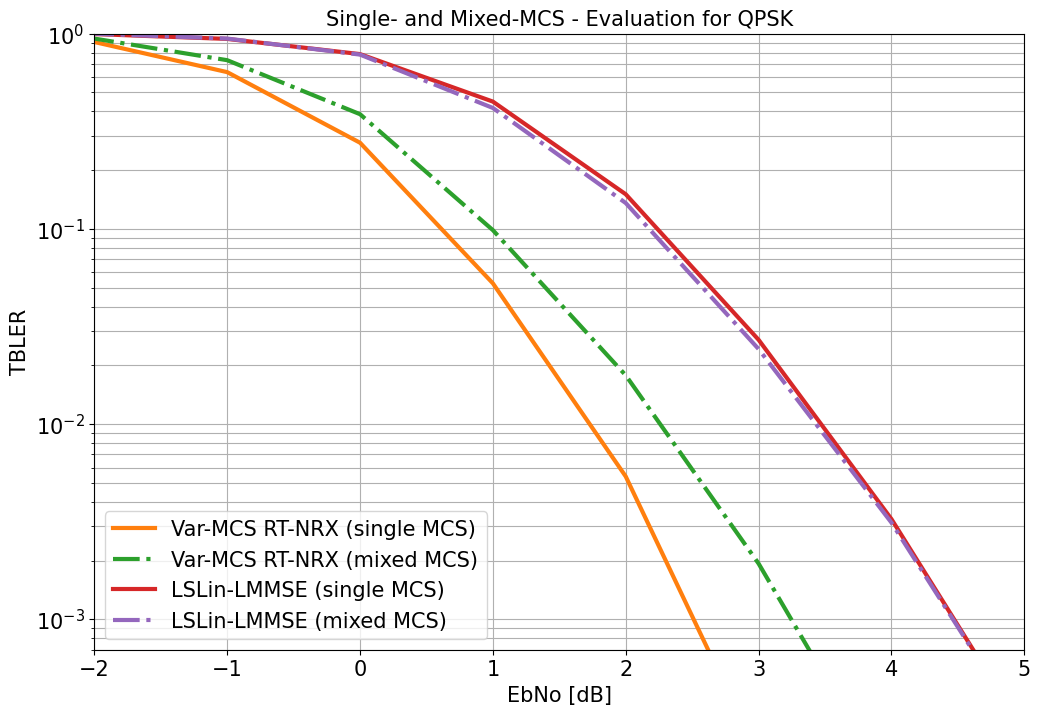

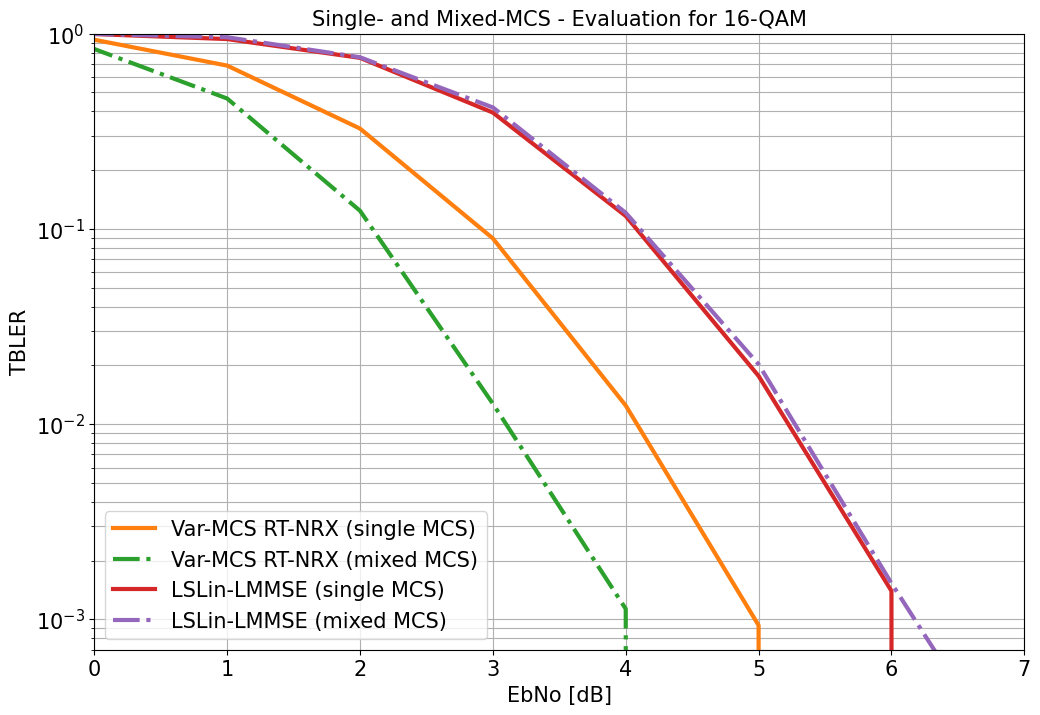

In [11]:
results_filename = "../results/mixed_mcs_results"
with open(results_filename,'rb') as f:
    ebno_db, BLERs_same_mcs, BLERs_mixed_mcs = pickle.load(f)

# Plot the single- and mixed-MCS performance for QPSK
fig, ax = plt.subplots(figsize=(12,8))

ax.semilogy(ebno_db, BLERs_same_mcs["Neural Receiver", 0], label="Var-MCS RT-NRX (single MCS)", color=f"C1", linewidth=3.0)
ax.semilogy(ebno_db, BLERs_mixed_mcs["Neural Receiver", 0], "-.", label="Var-MCS RT-NRX (mixed MCS)", color=f"C2", linewidth=3.0)
ax.semilogy(ebno_db, BLERs_same_mcs["Baseline - LS/lin+LMMSE", 0], label="LSLin-LMMSE (single MCS)", color=f"C3", linewidth=3.0)
ax.semilogy(ebno_db, BLERs_mixed_mcs["Baseline - LS/lin+LMMSE", 0], "-.", label="LSLin-LMMSE (mixed MCS)", color=f"C4", linewidth=3.0)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.grid(True, which="both")
ax.set_title("Single- and Mixed-MCS - Evaluation for QPSK", fontsize=15)
ax.set_xlabel("EbNo [dB]", fontsize=15)
ax.set_ylabel("TBLER", fontsize=15)
ax.legend(loc="lower left", fontsize=15)
ax.set_xlim([-2,5])
ax.set_ylim([7e-4,1]);

# Plot the single- and mixed-MCS performance for 16-QAM
fig, ax = plt.subplots(figsize=(12,8))

ax.semilogy(ebno_db, BLERs_same_mcs["Neural Receiver", 1], label="Var-MCS RT-NRX (single MCS)", color=f"C1", linewidth=3.0)
ax.semilogy(ebno_db, BLERs_mixed_mcs["Neural Receiver", 1], "-.", label="Var-MCS RT-NRX (mixed MCS)", color=f"C2", linewidth=3.0)
ax.semilogy(ebno_db, BLERs_same_mcs["Baseline - LS/lin+LMMSE", 1], label="LSLin-LMMSE (single MCS)", color=f"C3", linewidth=3.0)
ax.semilogy(ebno_db, BLERs_mixed_mcs["Baseline - LS/lin+LMMSE", 1], "-.", label="LSLin-LMMSE (mixed MCS)", color=f"C4", linewidth=3.0)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.grid(True, which="both")
ax.set_title("Single- and Mixed-MCS - Evaluation for 16-QAM", fontsize=15)
ax.set_xlabel("EbNo [dB]", fontsize=15)
ax.set_ylabel("TBLER", fontsize=15)
ax.legend(loc="lower left", fontsize=15)
ax.set_xlim([0,7])
ax.set_ylim([7e-4,1]);

We observe that the Var-MCS NRX can also handle mixed MCS scenarios. However, we see mildly degraded performance for QPSK when the interference is 16-QAM and mildly better performance for 16-QAM when the interference is QPSK, both compared to single-MCS scenarios. We can explain this effect due to the implicit multi-user interference cancellation implemented by the NRX and with the observation that 16-QAM is harder to detect than QPSK, and thereby 16-QAM interference is also harder to mitigate than QPSK interference.

For the classical receiver baseline, we observe that LMMSE equalization with Gaussian demapping performs similar in single- and mixed-MCS scenarios. This matches our expectation, as this receiver independently detects both UEs. However, we expect for detectors that jointly detect both UEs (e.g., K-Best) to show a similar characteristic as observed with the Var-MCS NRX. 

## References

[1] M. Honkala, D. Korpi and J. M. J. Huttunen, "[DeepRx: Fully Convolutional Deep Learning Receiver](https://arxiv.org/abs/2005.01494)," in IEEE Transactions on Wireless Communications, vol. 20, no. 6, pp. 3925-3940, June 2021.

[2] S. Cammerer, F. Aït Aoudia, J. Hoydis, A Oeldemann, A Roessler, T. Mayer and A. Keller, "[A Neural Receiver for 5G NR Multi-user MIMO]((https://arxiv.org/pdf/2312.02601))," IEEE Workshops (GC Wkshps), Dec. 2023.

[3] A. Gansekoele, A. Balatsoukas-Stimming, T. Brusse, M. Hoogendoorn, S. Bhulai, and R. van der Mei, "[A Machine Learning Approach for Simultaneous Demapping of QAM and APSK Constellations](https://arxiv.org/abs/2405.09909)," arXiv preprint arXiv:2405.09909, May 2024.

[4] F. Ait Aoudia and J. Hoydis, "[End-to-end learning for OFDM: From Neural Receivers to Pilotless Communication](https://arxiv.org/abs/2009.05261)," IEEE Trans. Wirel. Commun., vol. 21, no. 2, pp. 1049–1063, 2021.